In [46]:
import math
import hashlib
import inspect
import json
import pandas as pd
import numpy as np
import re
from hashlib import sha256
from collections import Counter
import string
import os
import random
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import WordPunctTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
import spacy
from spacy.matcher import Matcher
from spacy.lang.en import English
from spacy.matcher import Matcher
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score

In [23]:
train_data = pd.read_csv('data/train_data.csv')
test_data  = pd.read_csv('data/test_data_labeled.csv')
df_test_pred = pd.read_csv('data/test_data.csv')

In [24]:
print(train_data.shape)
print(train_data.label.value_counts(dropna=False))
train_data.head()

(44472, 3)
irrelevant    31045
debate         8909
agree          3678
clickbait       840
Name: label, dtype: int64


,title,text,label
0,PGA Spokesman and Tiger Woods' Agent Deny Drug...,Nicaraguan officials have appealed for witness...,irrelevant
1,Newly-Found Document Holds Eyewitness Account ...,"Dylan Thomas, who has been given the nickname ...",irrelevant
2,Dog found abandoned outside railway station wi...,It's being reported that one of the Batmobiles...,irrelevant
3,‘Evocative shape': Is Vladimir Putin trolling ...,"Boston - So lately, tongues have been wagging ...",irrelevant
4,‘Jihadi John’: The Islamic State killer behind...,LONDON — The identity of the masked executione...,agree


In [25]:
print(test_data.shape)
print(test_data.label.value_counts(dropna=False))
test_data.head()

(25413, 4)
irrelevant    18349
debate         4464
agree          1903
clickbait       697
Name: label, dtype: int64


,News ID,title,text,label
0,0,Saudi Arabia outlaws ‘tempting eyes’,"It's a safe bet that Sheikh Motlab al Nabet, s...",agree
1,1,No joke: 5-year-old billed for missing friend’...,"The president of Argentina, Cristina Kirchner,...",irrelevant
2,2,Adopting Potential Werewolves Is Routine Busin...,A 17-year-old transgender girl in Ohio committ...,irrelevant
3,3,Doc calls macabre 'selfie' claims completely c...,Raven-Symone did NOT file molestation charges ...,irrelevant
4,4,"Tail of survival: Buried cat, believed dead, c...",CAMP EDWARDS - The three Afghanistan National ...,irrelevant


In [18]:
print(df_test_pred.shape)
df_test_pred.head()

(25413, 3)


,News ID,title,text
0,0,Saudi Arabia outlaws ‘tempting eyes’,"It's a safe bet that Sheikh Motlab al Nabet, s..."
1,1,No joke: 5-year-old billed for missing friend’...,"The president of Argentina, Cristina Kirchner,..."
2,2,Adopting Potential Werewolves Is Routine Busin...,A 17-year-old transgender girl in Ohio committ...
3,3,Doc calls macabre 'selfie' claims completely c...,Raven-Symone did NOT file molestation charges ...
4,4,"Tail of survival: Buried cat, believed dead, c...",CAMP EDWARDS - The three Afghanistan National ...


In [21]:
# Preprocess text
# remove: stopwords and punctuation

filter_stopwords = True
remove_punkt = True

en_stopwords = stopwords.words('english')
tokenizer =  WordPunctTokenizer()

def preprocess(text, stopwords=False, remove_punkt=False, truncate=None):
    tokens = tokenizer.tokenize(text)
    tokens = [tok.lower() for tok in tokens]
    if stopwords:
        tokens = [tok for tok in tokens if tok not in en_stopwords]
    if remove_punkt:
        tokens = [tok for tok in tokens if tok not in string.punctuation]
    if truncate:
        tokens = tokens[:truncate]
    #tokens = [PorterStemmer().stem(tok) for tok in tokens]
    text_preprocessed = ' '.join(tokens)
    return text_preprocessed

In [26]:
train_data['text_preprocessed'] = train_data['text'].apply(preprocess, args=(filter_stopwords, remove_punkt, None))
train_data['title_preprocessed'] = train_data['title'].apply(preprocess, args=(filter_stopwords, remove_punkt, None))

test_data['text_preprocessed'] = test_data['text'].apply(preprocess, args=(filter_stopwords, remove_punkt, None))
test_data['title_preprocessed'] = test_data['title'].apply(preprocess, args=(filter_stopwords, remove_punkt, None))

In [27]:
train_data.head()

,title,text,label,text_preprocessed,title_preprocessed
0,PGA Spokesman and Tiger Woods' Agent Deny Drug...,Nicaraguan officials have appealed for witness...,irrelevant,nicaraguan officials appealed witnesses meteor...,pga spokesman tiger woods agent deny drug susp...
1,Newly-Found Document Holds Eyewitness Account ...,"Dylan Thomas, who has been given the nickname ...",irrelevant,dylan thomas given nickname spider man friends...,newly found document holds eyewitness account ...
2,Dog found abandoned outside railway station wi...,It's being reported that one of the Batmobiles...,irrelevant,reported one batmobiles currently detroit batm...,dog found abandoned outside railway station su...
3,‘Evocative shape': Is Vladimir Putin trolling ...,"Boston - So lately, tongues have been wagging ...",irrelevant,boston lately tongues wagging due recent story...,‘ evocative shape ': vladimir putin trolling w...
4,‘Jihadi John’: The Islamic State killer behind...,LONDON — The identity of the masked executione...,agree,london — identity masked executioner clutching...,‘ jihadi john ’: islamic state killer behind m...


In [29]:
#Feature 1 - overlap of headline with title

def overlap_feature(df):
    headline = df['title_preprocessed']
    headline_toks = headline.split()
    headline_num_toks = len(headline_toks)
    count_toks = 0
    for tok in headline_toks:
        if tok in df['text_preprocessed']:
            count_toks += 1
    return 1.0 * count_toks / headline_num_toks

In [31]:
train_data['overlap'] = train_data.apply(overlap_feature, axis=1)
test_data['overlap'] = test_data.apply(overlap_feature, axis=1)
train_data.head()

,title,text,label,text_preprocessed,title_preprocessed,overlap
0,PGA Spokesman and Tiger Woods' Agent Deny Drug...,Nicaraguan officials have appealed for witness...,irrelevant,nicaraguan officials appealed witnesses meteor...,pga spokesman tiger woods agent deny drug susp...,0.000000
1,Newly-Found Document Holds Eyewitness Account ...,"Dylan Thomas, who has been given the nickname ...",irrelevant,dylan thomas given nickname spider man friends...,newly found document holds eyewitness account ...,0.111111
2,Dog found abandoned outside railway station wi...,It's being reported that one of the Batmobiles...,irrelevant,reported one batmobiles currently detroit batm...,dog found abandoned outside railway station su...,0.000000
3,‘Evocative shape': Is Vladimir Putin trolling ...,"Boston - So lately, tongues have been wagging ...",irrelevant,boston lately tongues wagging due recent story...,‘ evocative shape ': vladimir putin trolling w...,0.100000
4,‘Jihadi John’: The Islamic State killer behind...,LONDON — The identity of the masked executione...,agree,london — identity masked executioner clutching...,‘ jihadi john ’: islamic state killer behind m...,0.363636


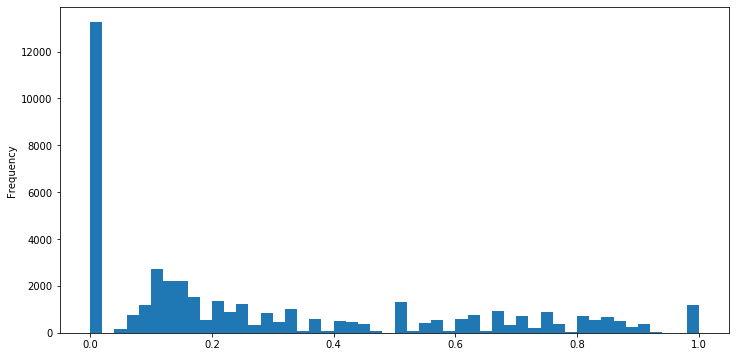

In [34]:
train_data.overlap.plot.hist(bins=50, figsize=(12, 6));

In [36]:
# Feature 2 - clickbait related words

# train_data[train_data['label']=='clickbait']

def clickbait_manual_features(df, where='both'):
    clickbait_words_text_not_headline = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'urban myth',
        'unsupported',
        'debunk',
        'viral',
        'doubt',
        'rumor'
    ]
    
    headline = df['title_preprocessed']
    text = df['text_preprocessed']
    
    counts = {
        'both': 0,
        'head': 0,
        'body': 0,
        'none': 0,
    }
    for w in clickbait_words_text_not_headline:
        if w in text and w in headline:
            counts['both'] += 1
        elif w in headline:
            counts['head'] += 1
        elif w in text:
            counts['body'] += 1
        else:
            counts['none'] += 1

    return counts[where]

In [37]:
train_data['clickbait_word_count_both'] = train_data.apply(clickbait_manual_features, axis=1, args=('both', ))
train_data['clickbait_word_count_head'] = train_data.apply(clickbait_manual_features, axis=1, args=('head', ))
train_data['clickbait_word_count_body'] = train_data.apply(clickbait_manual_features, axis=1, args=('body', ))

test_data['clickbait_word_count_both'] = test_data.apply(clickbait_manual_features, axis=1, args=('both', ))
test_data['clickbait_word_count_head'] = test_data.apply(clickbait_manual_features, axis=1, args=('head', ))
test_data['clickbait_word_count_body'] = test_data.apply(clickbait_manual_features, axis=1, args=('body', ))

train_data.head()

,title,text,label,text_preprocessed,title_preprocessed,overlap,clickbait_word_count_both,clickbait_word_count_head,clickbait_word_count_body
0,PGA Spokesman and Tiger Woods' Agent Deny Drug...,Nicaraguan officials have appealed for witness...,irrelevant,nicaraguan officials appealed witnesses meteor...,pga spokesman tiger woods agent deny drug susp...,0.000000,0,0,0
1,Newly-Found Document Holds Eyewitness Account ...,"Dylan Thomas, who has been given the nickname ...",irrelevant,dylan thomas given nickname spider man friends...,newly found document holds eyewitness account ...,0.111111,0,0,0
2,Dog found abandoned outside railway station wi...,It's being reported that one of the Batmobiles...,irrelevant,reported one batmobiles currently detroit batm...,dog found abandoned outside railway station su...,0.000000,0,0,0
3,‘Evocative shape': Is Vladimir Putin trolling ...,"Boston - So lately, tongues have been wagging ...",irrelevant,boston lately tongues wagging due recent story...,‘ evocative shape ': vladimir putin trolling w...,0.100000,0,0,3
4,‘Jihadi John’: The Islamic State killer behind...,LONDON — The identity of the masked executione...,agree,london — identity masked executioner clutching...,‘ jihadi john ’: islamic state killer behind m...,0.363636,0,0,0


In [38]:
#Feature 3 - negatives

def negative_manual_features(df, where='body'):
    negation_particles = [
        'not',
        'n\'t'
    ]
    
    headline = df['title']
    text = df['text']
    
    counts = {
        'head': 0,
        'body': 0
    }
    for w in negation_particles:
        if w in headline:
            counts['head'] += 1
        if w in text:
            counts['body'] += 1

    return counts[where]


train_data['negation_body'] = train_data.apply(negative_manual_features, axis=1, args=('body', ))
train_data['negation_head'] = train_data.apply(negative_manual_features, axis=1, args=('head', ))

test_data['negation_body'] = test_data.apply(negative_manual_features, axis=1, args=('body', ))
test_data['negation_head'] = test_data.apply(negative_manual_features, axis=1, args=('head', ))

train_data.head()

,title,text,label,text_preprocessed,title_preprocessed,overlap,clickbait_word_count_both,clickbait_word_count_head,clickbait_word_count_body,negation_body,negation_head
0,PGA Spokesman and Tiger Woods' Agent Deny Drug...,Nicaraguan officials have appealed for witness...,irrelevant,nicaraguan officials appealed witnesses meteor...,pga spokesman tiger woods agent deny drug susp...,0.000000,0,0,0,1,0
1,Newly-Found Document Holds Eyewitness Account ...,"Dylan Thomas, who has been given the nickname ...",irrelevant,dylan thomas given nickname spider man friends...,newly found document holds eyewitness account ...,0.111111,0,0,0,0,0
2,Dog found abandoned outside railway station wi...,It's being reported that one of the Batmobiles...,irrelevant,reported one batmobiles currently detroit batm...,dog found abandoned outside railway station su...,0.000000,0,0,0,2,0
3,‘Evocative shape': Is Vladimir Putin trolling ...,"Boston - So lately, tongues have been wagging ...",irrelevant,boston lately tongues wagging due recent story...,‘ evocative shape ': vladimir putin trolling w...,0.100000,0,0,3,2,0
4,‘Jihadi John’: The Islamic State killer behind...,LONDON — The identity of the masked executione...,agree,london — identity masked executioner clutching...,‘ jihadi john ’: islamic state killer behind m...,0.363636,0,0,0,1,0


In [41]:
# Feature 4 - tfidf cosine similarity


def cosine_similarity_feature(df, vectorizer):
    headline = df['title_preprocessed']
    text = df['text_preprocessed']

    head_tfidf = vectorizer.transform([headline])
    text_tfidf = vectorizer.transform([text])

    cosineSimilarities = cosine_similarity(head_tfidf, text_tfidf).flatten()
    return cosineSimilarities[0]



vocabulary = set(' '.join(train_data.text_preprocessed.to_list()).split())
vec = TfidfVectorizer(vocabulary=vocabulary)
vec.fit(train_data.text_preprocessed)

train_data['cos_similariry'] = train_data.apply(cosine_similarity_feature, axis=1, args=(vec, ))
test_data['cos_similariry'] = test_data.apply(cosine_similarity_feature, axis=1, args=(vec, ))

train_data.head()


,title,text,label,text_preprocessed,title_preprocessed,overlap,clickbait_word_count_both,clickbait_word_count_head,clickbait_word_count_body,negation_body,negation_head,cos_similariry
0,PGA Spokesman and Tiger Woods' Agent Deny Drug...,Nicaraguan officials have appealed for witness...,irrelevant,nicaraguan officials appealed witnesses meteor...,pga spokesman tiger woods agent deny drug susp...,0.000000,0,0,0,1,0,0.000000
1,Newly-Found Document Holds Eyewitness Account ...,"Dylan Thomas, who has been given the nickname ...",irrelevant,dylan thomas given nickname spider man friends...,newly found document holds eyewitness account ...,0.111111,0,0,0,0,0,0.005630
2,Dog found abandoned outside railway station wi...,It's being reported that one of the Batmobiles...,irrelevant,reported one batmobiles currently detroit batm...,dog found abandoned outside railway station su...,0.000000,0,0,0,2,0,0.000000
3,‘Evocative shape': Is Vladimir Putin trolling ...,"Boston - So lately, tongues have been wagging ...",irrelevant,boston lately tongues wagging due recent story...,‘ evocative shape ': vladimir putin trolling w...,0.100000,0,0,3,2,0,0.010286
4,‘Jihadi John’: The Islamic State killer behind...,LONDON — The identity of the masked executione...,agree,london — identity masked executioner clutching...,‘ jihadi john ’: islamic state killer behind m...,0.363636,0,0,0,1,0,0.157111


In [43]:
# Pipelines

class Selector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a column from the dataframe to perform additional transformations on
    """ 
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y=None):
        return self
    
class TextSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def transform(self, X):
        return X[self.key]
    
class NumberSelector(Selector):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def transform(self, X):
        return X[[self.key]]
    
    
def build_pipe_and_fit(features, train_df):

    feats = []
    for feature, ftype in features.items():
        if ftype == 'text':
            feature_pipe = Pipeline([
                ('selector', TextSelector(feature)),
                ('tfidf', TfidfVectorizer(max_features=500))
            ])
        elif ftype == 'number':
            feature_pipe = Pipeline([
                ('selector', NumberSelector(feature)),
                ('standard', StandardScaler())
            ])
        feats.append((feature, feature_pipe))
    
    feats_pipe = FeatureUnion(feats)

    pipe = Pipeline([
        ("features", feats_pipe),
        ("clf", RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1))
    ])
    
    pipe.fit(train_df, train_df['label'])

    return pipe


def predict(pipe, test_df):

    y_pred = pipe.predict(test_df)
    
    accuracy = accuracy_score(test_df['label'], y_pred)
    f1 = f1_score(test_df['label'], y_pred, average="macro")
    print('Accuracy: {}'.format(accuracy))
    print('F1-score: {}'.format(f1))
    print(['agree', 'clickbait', 'debate', 'irrelevant'])
    print(f1_score(test_df['label'], y_pred, labels=['agree', 'clickbait', 'debate', 'irrelevant'], average=None))
    return

In [44]:
# Testes

feature_dict = {
    'overlap': 'number',
    'cos_similariry': 'number',
    'clickbait_word_count_both': 'number',# -> made it worse
    'clickbait_word_count_head': 'number',
    'clickbait_word_count_body': 'number',
    'negation_body': 'number',# -> made it worse
    'negation_head': 'number',# -> made it worse
    'title_preprocessed': 'text',
    'text_preprocessed': 'text',
}


pipe =  build_pipe_and_fit(feature_dict, train_data)


In [47]:
predict(pipe, test_data)

Accuracy: 0.8653051587770039
F1-score: 0.5320426315926171
['agree', 'clickbait', 'debate', 'irrelevant']
[0.47310312 0.         0.68386953 0.97119788]


In [48]:
feature_dict2 = {
    'overlap': 'number',
    'cos_similariry': 'number',
#     'clickbait_word_count_both': 'number',# -> made it worse
    'clickbait_word_count_head': 'number',
    'clickbait_word_count_body': 'number',
#     'negation_body': 'number',# -> made it worse
#     'negation_head': 'number',# -> made it worse
    'title_preprocessed': 'text',
    'text_preprocessed': 'text',
}


pipe2 =  build_pipe_and_fit(feature_dict2, train_data)
predict(pipe2, test_data)

Accuracy: 0.8583402195726597
F1-score: 0.5264162118485529
['agree', 'clickbait', 'debate', 'irrelevant']
[0.46076413 0.00285307 0.67509426 0.9669534 ]
